## This script contains the following:

1. Importing your libraries and data
2. Subsetting, wrangling, and cleaning time-series data
3. Time series analysis: decomposition
4. Testing for stationarity
5. Stationarizing the Federal Reserve Economic Data¶

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'EfBXv9x9BSimCk84mLyp'

In [3]:
# Importing the Federal Reserve Economic Data "Gross Domestic Product: Implicit Price Deflator" variable.

data = quandl.get('FRED/GDPDEF')

In [4]:
data.head(5)

,Value
Date,
1947-01-01,11.952
1947-04-01,12.122
1947-07-01,12.326
1947-10-01,12.630
1948-01-01,12.731


In [5]:
data.shape

(300, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

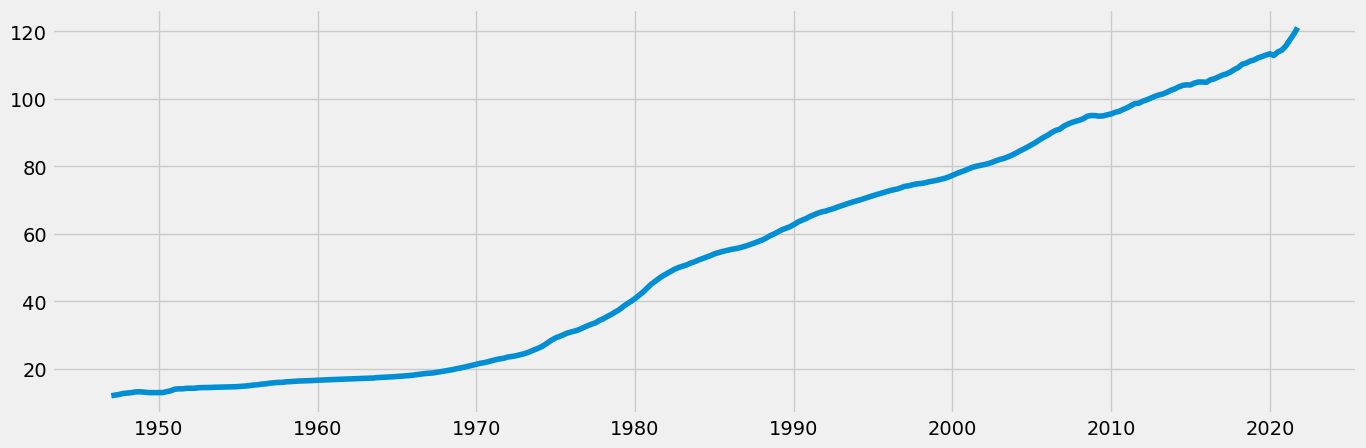

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [10]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [11]:
data_2.head()

,Date,Value
0,1947-01-01,11.952
1,1947-04-01,12.122
2,1947-07-01,12.326
3,1947-10-01,12.630
4,1948-01-01,12.731


In [13]:
#I'm going to take from 1970 - curve starts to show steady increase in gdp from that date - curious to include it

data_sub = data_2.loc[(data_2['Date'] >= '1970-01-01') & (data_2['Date'] < '2020-06-01')]

In [14]:
data_sub.shape

(202, 2)

In [15]:
data_sub.head()

,Date,Value
92,1970-01-01,21.280
93,1970-04-01,21.577
94,1970-07-01,21.754
95,1970-10-01,22.042
96,1971-01-01,22.376


In [16]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1970-01-01,21.280
1970-04-01,21.577
1970-07-01,21.754
1970-10-01,22.042
1971-01-01,22.376


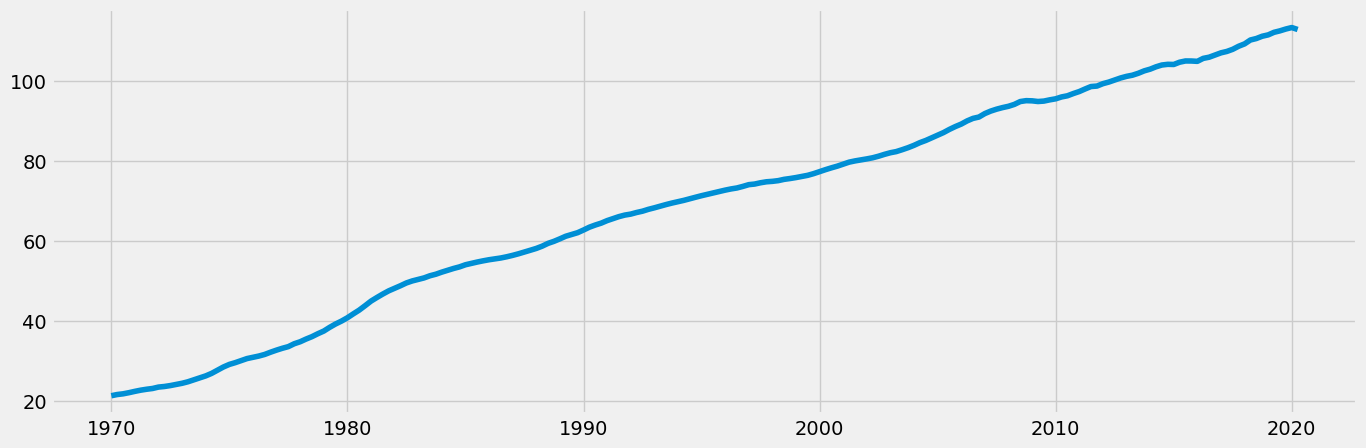

In [17]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [18]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [19]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time series analysis: decomposition

In [20]:
# Decompose the time series using an linear (additive) model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [22]:
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

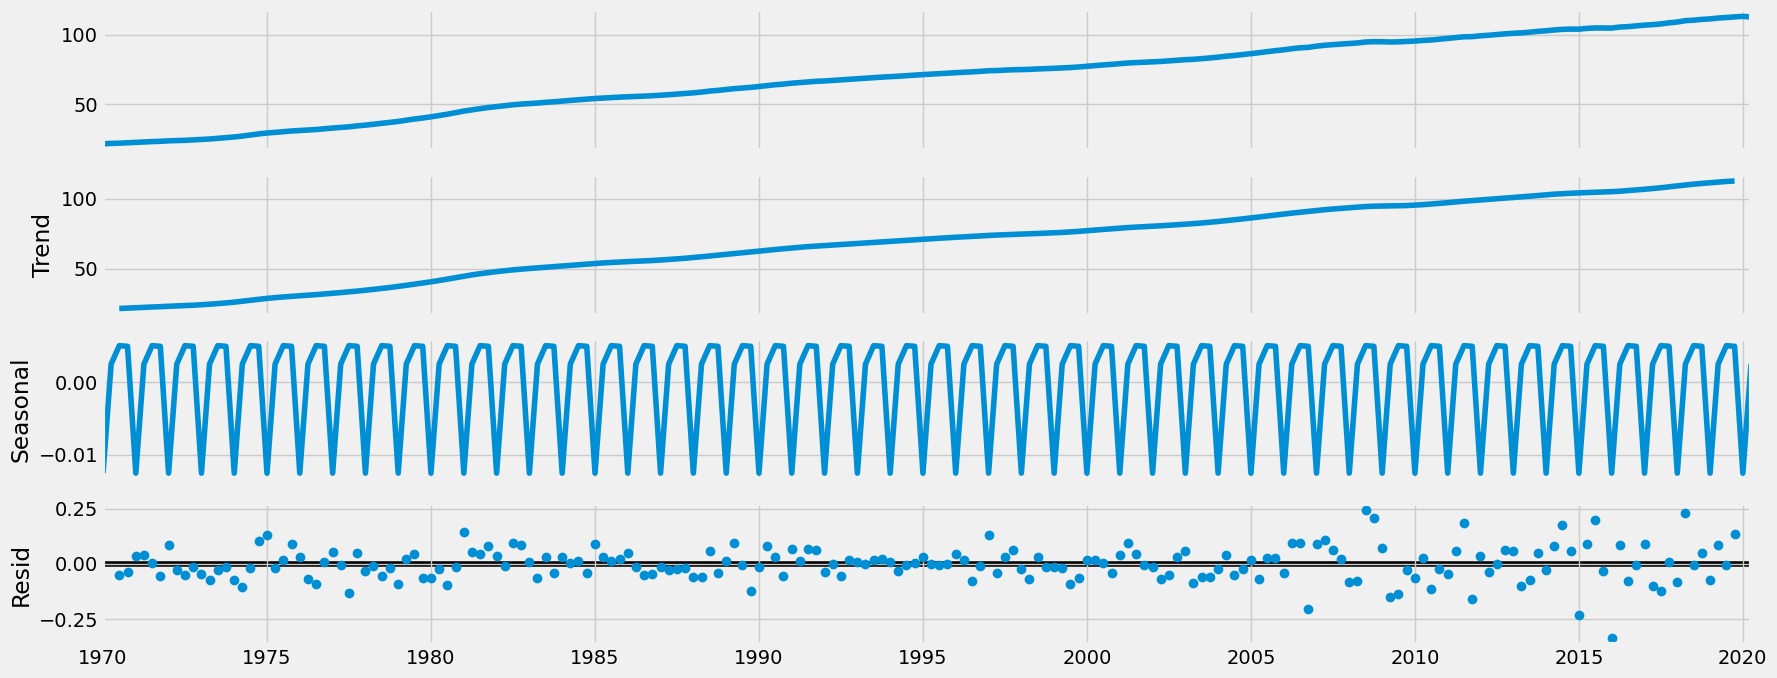

In [23]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity 

In [24]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.083422
p-value                          0.251233
Number of Lags Used              8.000000
Number of Observations Used    193.000000
Critical Value (1%)             -3.464694
Critical Value (5%)             -2.876635
Critical Value (10%)            -2.574816
dtype: float64


Interpretation:

The test statistic of -2.083422 is greater than the critical values at all confidence levels (1%, 5%, and 10%). This suggests that we do not have enough evidence to reject the null hypothesis of non-stationarity.
p-value:

The p-value is higher than the common significance level of 0.05. This further supports the conclusion that we do not have enough evidence to reject the null hypothesis.

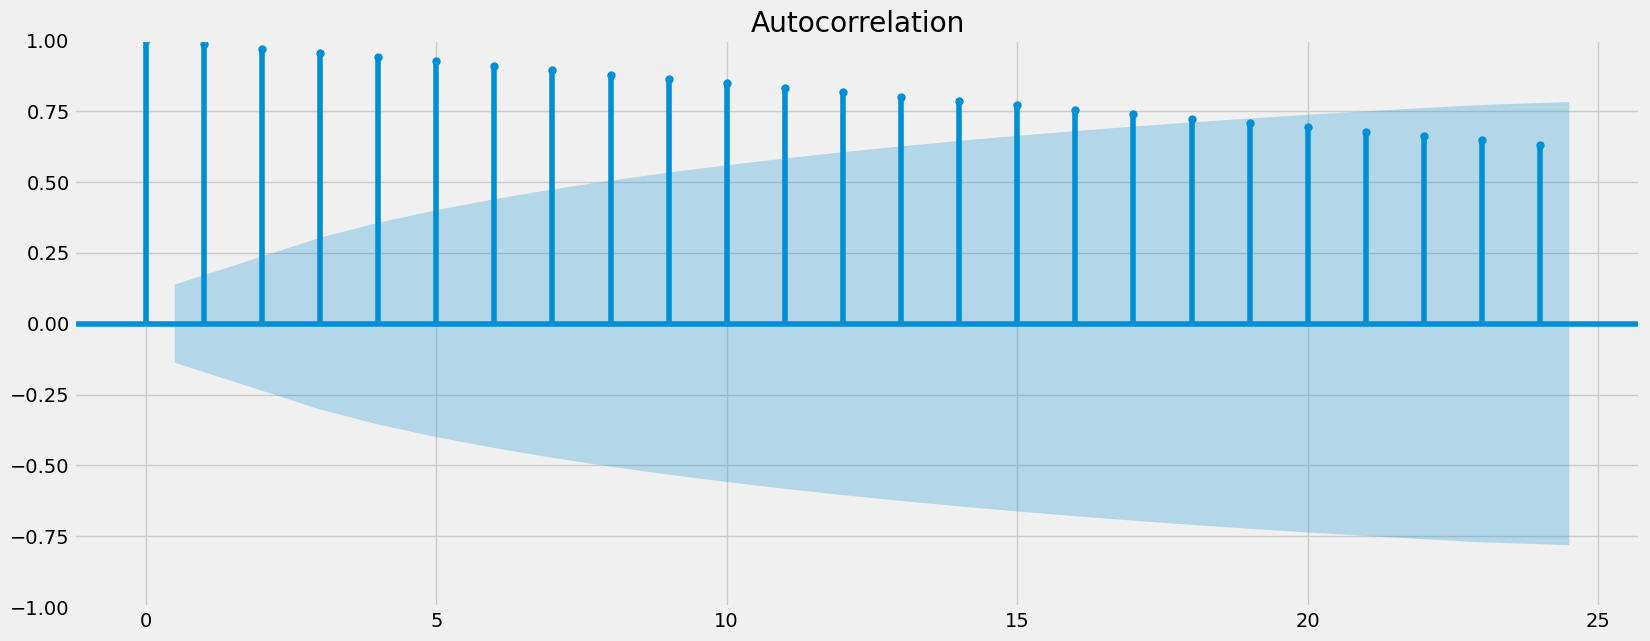

In [25]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

Lags outside the confidence level shows significant correlation with each other. Many lags beyond this interval, we can deduce that data is non-stationary

### 4. making our data Stationary

In [26]:
data_diff = data_sub - data_sub.shift(1)

In [28]:
# Remove values as a result of differencing 
data_diff.dropna(inplace = True)

In [29]:
data_diff.head()

,Value
datetime,
1970-04-01,0.297
1970-07-01,0.177
1970-10-01,0.288
1971-01-01,0.334
1971-04-01,0.294


In [30]:
data_diff.columns

Index(['Value'], dtype='object')

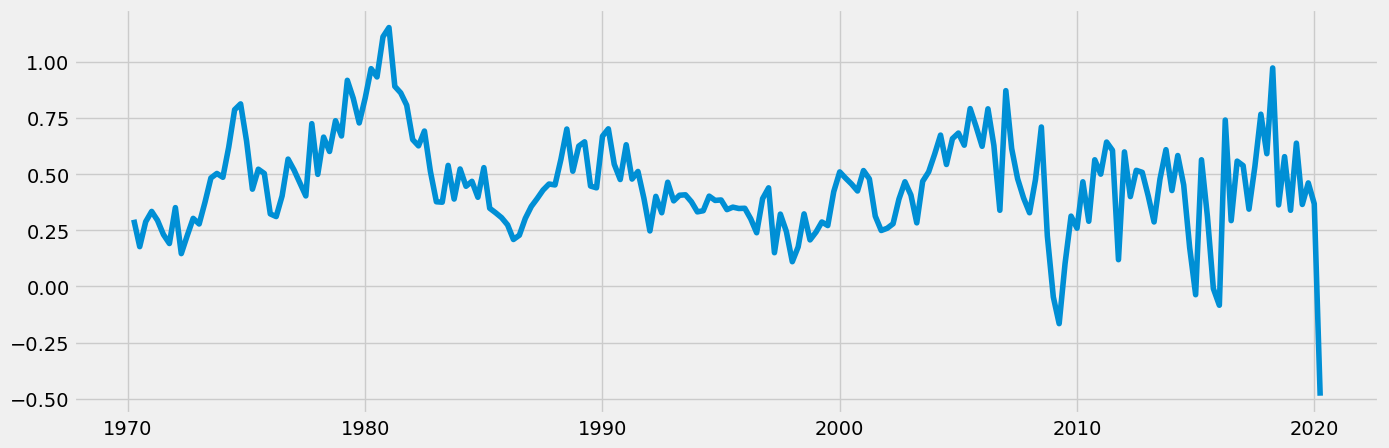

In [31]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

Looks a lot better - let's tet

In [32]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.207452
p-value                          0.000640
Number of Lags Used              7.000000
Number of Observations Used    193.000000
Critical Value (1%)             -3.464694
Critical Value (5%)             -2.876635
Critical Value (10%)            -2.574816
dtype: float64


The test statistic of -4.207452 is lower than the critical values at all confidence levels. This suggests that we have enough evidence to reject the null hypothesis of non-stationarity.

The low p-value and the test statistic falling below the critical values at all confidence levels provide strong evidence that the data is stationary. 

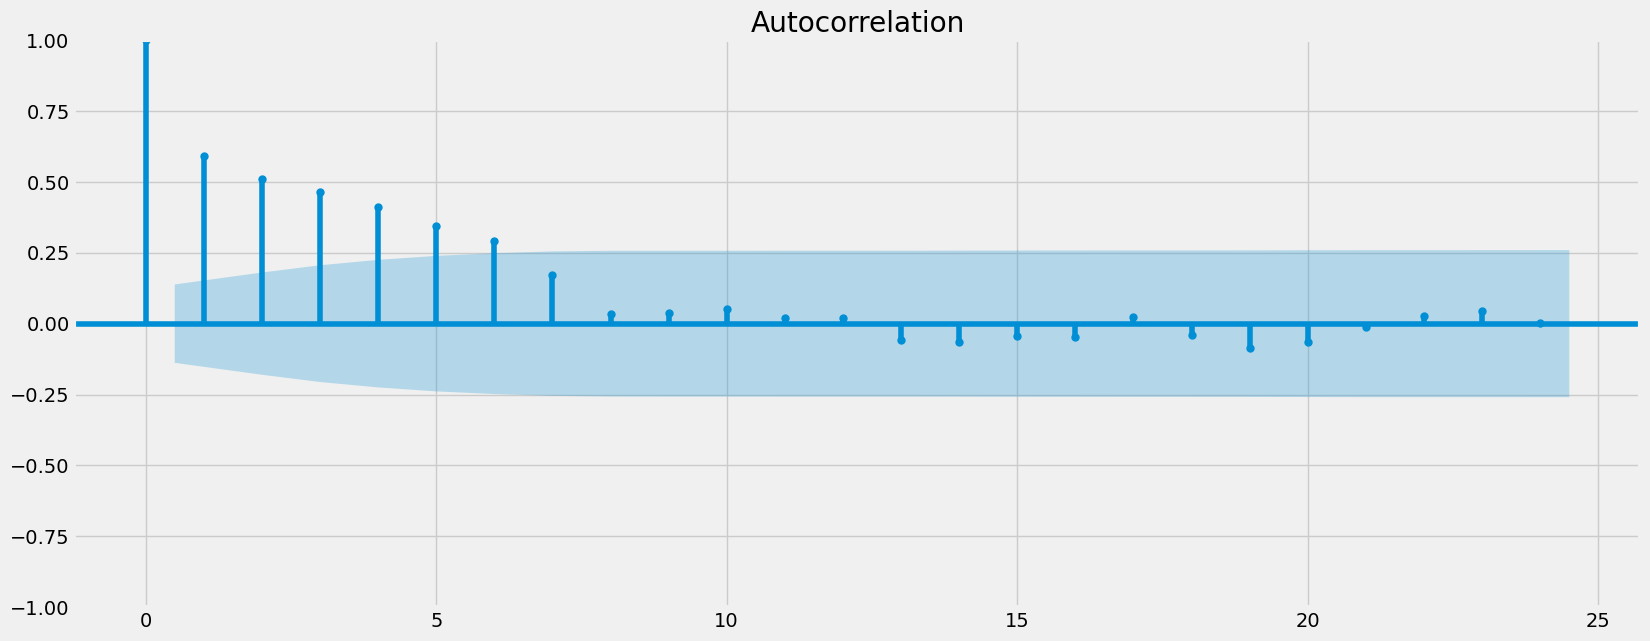

In [33]:
#let's see autocorrelation

plot_acf(data_diff)
plt.show()

Although not perfect - this shows imporovement don't think it is necessary to conduct another round of differencing